# Librerias y carga de datos

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import ast

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using:", device)


url = "https://raw.githubusercontent.com/Kinanel07/PROYECTO-TEORIA-predecir-viralidad/refs/heads/main/df_25.csv" ## 25% VIRAL
df = pd.read_csv(url)



Using: cuda


# Preprocesamiento de datos y creacion de nuevas variables

## Pasar categorias a numerico

In [2]:

LABELS = [
    "comedy", "dance", "sports", "gaming", "educational",
    "vehicles", "beauty", "food", "pets", "technology",
    "music", "unidentified", "other"
]


def fix_category_list(x):
    if isinstance(x, list):
        return x

    if isinstance(x, str):

        x = x.strip()
        if "'" in x or '"' in x:
            try:
                return ast.literal_eval(x)
            except:
                pass

        x_clean = re.sub(r'([A-Za-z_]+)', r'"\1"', x)

        try:
            return ast.literal_eval(x_clean)
        except:
            return None

    return None

df["categories"] = df["categories"].apply(fix_category_list)

df["categories"] = df["categories"].apply(
    lambda x: eval(x) if isinstance(x, str) else x
)


for label in LABELS:
    df[f"cat_{label}"] = df["categories"].apply(lambda lst: 1 if label in lst else 0)


cat_cols = [f"cat_{label}" for label in LABELS]

## Nuevas variables

In [3]:
df["likes_per_follower"] = df["likes"] / (df["followers"] + 1)
df["comments_per_follower"] = df["comments"] / (df["followers"] + 1)
df["shares_per_follower"] = df["shares"] / (df["followers"] + 1)


num_cols = [
    "is_song",
    "duration_sec",
    "followers",
    "following",
    "likes",
    "comments",
    "shares",
    "engagement_rate",
    "likes_per_follower",
    "comments_per_follower",
    "shares_per_follower"
]


# Modelo

In [4]:
X = pd.concat([df[num_cols], df[cat_cols]], axis=1).astype(float)
y = df["viral"].astype(int)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

class ViralClassifier(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 160),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(160, 80),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(80, 1)
        )

    def forward(self, x):
        logits = self.net(x)
        return logits, torch.sigmoid(logits)


def train_model(X_train, y_train, epochs=25, patience=5):

    model = ViralClassifier(X_train.shape[1]).to(device)

    X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_t = torch.tensor(y_train.values, dtype=torch.float32).to(device)


    pos_weight = torch.tensor([5.0]).to(device)

    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = optim.AdamW(model.parameters(), lr=0.001)

    best_loss = float("inf")
    patience_counter = 0

    for epoch in range(epochs):

        model.train()
        optimizer.zero_grad()

        logits, _ = model(X_train_t)
        loss = criterion(logits.squeeze(), y_train_t)

        loss.backward()
        optimizer.step()

        print(f"Epoch {epoch+1}/{epochs} | Loss: {loss.item():.5f}")


        if loss.item() < best_loss:
            best_loss = loss.item()
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("⏹ Early Stopping activado")
                break

    model.load_state_dict(best_model_state)
    return model


model = train_model(X_train, y_train, epochs=25, patience=5)



def find_best_threshold(model, X_val, y_val):
    X_val_t = torch.tensor(X_val, dtype=torch.float32).to(device)

    with torch.no_grad():
        _, preds = model(X_val_t)
        preds = preds.cpu().numpy().flatten()

    thresholds = np.arange(0.1, 0.9, 0.02)

    best_t = 0.5
    best_f1 = 0

    for t in thresholds:
        preds_bin = (preds >= t).astype(int)
        f1 = f1_score(y_val, preds_bin)

        if f1 > best_f1:
            best_f1 = f1
            best_t = t

    print(f"\n Mejor threshold encontrado: {best_t}")
    return best_t


best_t = find_best_threshold(model, X_val, y_val)


Epoch 1/25 | Loss: 1.39335
Epoch 2/25 | Loss: 1.35177
Epoch 3/25 | Loss: 1.31914
Epoch 4/25 | Loss: 1.27453
Epoch 5/25 | Loss: 1.24297
Epoch 6/25 | Loss: 1.20726
Epoch 7/25 | Loss: 1.16858
Epoch 8/25 | Loss: 1.13750
Epoch 9/25 | Loss: 1.10029
Epoch 10/25 | Loss: 1.05711
Epoch 11/25 | Loss: 1.02694
Epoch 12/25 | Loss: 0.98467
Epoch 13/25 | Loss: 0.95774
Epoch 14/25 | Loss: 0.92965
Epoch 15/25 | Loss: 0.88629
Epoch 16/25 | Loss: 0.85407
Epoch 17/25 | Loss: 0.81902
Epoch 18/25 | Loss: 0.79224
Epoch 19/25 | Loss: 0.76033
Epoch 20/25 | Loss: 0.72880
Epoch 21/25 | Loss: 0.68910
Epoch 22/25 | Loss: 0.66348
Epoch 23/25 | Loss: 0.63680
Epoch 24/25 | Loss: 0.60022
Epoch 25/25 | Loss: 0.57538

 Mejor threshold encontrado: 0.7200000000000001


# Evaluación modelo

Accuracy: 0.9
Precision: 0.7419354838709677
Recall: 0.92
F1: 0.8214285714285714
AUC: 0.976


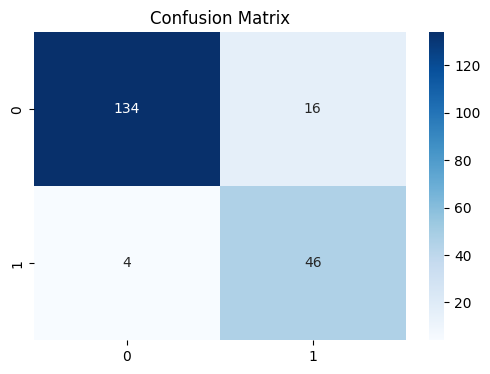

In [6]:
def evaluate_model(model, X_val, y_val, threshold):

    X_val_t = torch.tensor(X_val, dtype=torch.float32).to(device)

    with torch.no_grad():
        _, preds = model(X_val_t)
        preds = preds.cpu().numpy().flatten()

    preds_bin = (preds >= threshold).astype(int)
    y_true = y_val.values


    print("Accuracy:", accuracy_score(y_true, preds_bin))
    print("Precision:", precision_score(y_true, preds_bin))
    print("Recall:", recall_score(y_true, preds_bin))
    print("F1:", f1_score(y_true, preds_bin))
    print("AUC:", roc_auc_score(y_true, preds))

    cm = confusion_matrix(y_true, preds_bin)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.show()


evaluate_model(model, X_val, y_val, best_t)